<a href="https://colab.research.google.com/github/jafetimbre/verbose-projects/blob/master/infosec/nsl-kdd-ids/ids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column

# from sklearn.ensemble import RandomForestClassifier

In [2]:
train_url = "https://raw.githubusercontent.com/jafetimbre/verbose-projects/master/infosec/datasets/NSL-KDD/simple/KDDTrain%2B.txt"
train20_url = "https://raw.githubusercontent.com/jafetimbre/verbose-projects/master/infosec/datasets/NSL-KDD/simple/KDDTrain%2B_20Percent.txt"

test_url = "https://raw.githubusercontent.com/jafetimbre/verbose-projects/master/infosec/datasets/NSL-KDD/simple/KDDTest%2B.txt"
test_21_url = "https://raw.githubusercontent.com/jafetimbre/verbose-projects/master/infosec/datasets/NSL-KDD/simple/KDDTest-21.txt"

In [3]:
nls_columns = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "class",
    "undefined"
    ]
    
print(len(nls_columns))

43


In [4]:
df = pd.read_csv(train_url, header=None, names=nls_columns)

In [5]:
attack_types = {
    "normal": "normal",
    
    "back": "DoS",
    "land": "DoS",
    "neptune": "DoS",
    "pod": "DoS",
    "smurf": "DoS",
    "teardrop": "DoS",
    "mailbomb": "DoS",
    "apache2": "DoS",
    "processtable": "DoS",
    "udpstorm": "DoS",
    
    "ipsweep": "Probe",
    "nmap": "Probe",
    "portsweep": "Probe",
    "satan": "Probe",
    "mscan": "Probe",
    "saint": "Probe",

    "ftp_write": "R2L",
    "guess_passwd": "R2L",
    "imap": "R2L",
    "multihop": "R2L",
    "phf": "R2L",
    "spy": "R2L",
    "warezclient": "R2L",
    "warezmaster": "R2L",
    "sendmail": "R2L",
    "named": "R2L",
    "snmpgetattack": "R2L",
    "snmpguess": "R2L",
    "xlock": "R2L",
    "xsnoop": "R2L",
    "worm": "R2L",
    
    "buffer_overflow": "U2R",
    "loadmodule": "U2R",
    "perl": "U2R",
    "rootkit": "U2R",
    "httptunnel": "U2R",
    "ps": "U2R",    
    "sqlattack": "U2R",
    "xterm": "U2R"
}

In [6]:
df["attack_type"] = df["class"].apply(lambda x: attack_types[x])
df[["class", "attack_type"]]

,class,attack_type
0,normal,normal
1,normal,normal
2,neptune,DoS
3,normal,normal
4,normal,normal
...,...,...
125968,neptune,DoS
125969,normal,normal
125970,normal,normal
125971,neptune,DoS


In [7]:
df["attack_type"].value_counts()

normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: attack_type, dtype: int64

In [8]:
df["class"].value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: class, dtype: int64

In [9]:
SEL_ATTACK = "satan"

In [30]:
# drop unused columns
tmp = df.drop(["attack_type", "undefined"], axis=1)

# Filter normal and selected attack traffic 
tmp = tmp.loc[(df["class"] == "normal") | (df["class"] == SEL_ATTACK)]

# reset the index
all_data = tmp.reset_index(drop=True)

# Check ratios of the two states
all_data["class"].value_counts(normalize=True)

normal    0.948814
satan     0.051186
Name: class, dtype: float64

In [31]:
# Delete columns with only 0's
all_data = all_data.loc[:, (all_data != 0).any(axis=0)]

In [32]:
remap_dict = { 
    "class": {
        "normal": 0.0,
        "satan": 1.0
    }
}
all_data = all_data.replace(remap_dict)

non_num_cols = all_data.select_dtypes(exclude=[np.number]).columns
all_data = all_data.drop(columns=non_num_cols)
all_data.head()

,duration,src_bytes,dst_bytes,land,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0.0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0.0
2,0,232,8153,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0.0
3,0,199,420,0,0,0,0,1,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
4,0,287,2251,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,7,0.0,0.0,0.0,0.0,1.00,0.00,0.43,8,219,1.00,0.00,0.12,0.03,0.00,0.00,0.00,0.00,0.0


In [33]:
# Min-max normalization
all_data = (all_data-all_data.min())/(all_data.max()-all_data.min())
all_data.head()

,duration,src_bytes,dst_bytes,land,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,0.000005,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0.0
1,0.0,0.000002,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025440,0.001957,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0.0
2,0.0,0.000003,0.00116,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009785,0.009785,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0.0
3,0.0,0.000002,0.00006,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058708,0.062622,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
4,0.0,0.000003,0.00032,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005871,0.013699,0.0,0.0,0.0,0.0,1.00,0.00,0.43,0.031373,0.858824,1.00,0.00,0.12,0.03,0.00,0.00,0.00,0.00,0.0


In [49]:
# prepare test data
df = pd.read_csv(test_url, header=None, names=nls_columns)
df = df.loc[:, df.columns.isin(all_data.columns)]
tmp = df.loc[(df["class"] == "normal") | (df["class"] == SEL_ATTACK)]
test_data = tmp.reset_index(drop=True)
test_data = test_data.replace(remap_dict)
test_data = (test_data-test_data.min())/(test_data.max()-test_data.min())
test_data = test_data.fillna(0.0)
test_data

,duration,src_bytes,dst_bytes,land,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.000037,0.002064,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.525490,0.337255,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,0.0
1,0.000000,0.000042,0.010784,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007828,0.007828,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.607843,1.000000,1.00,0.00,0.01,0.03,0.01,0.0,0.00,0.00,0.0
2,0.000000,0.000162,0.000288,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.005871,0.0,0.0,0.0,0.0,1.0,0.0,1.00,1.000000,0.109804,0.11,0.72,0.00,0.00,0.00,0.0,0.72,0.04,0.0
3,0.000000,0.000052,0.000347,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064579,0.091977,0.0,0.0,0.0,0.0,1.0,0.0,0.04,0.592157,1.000000,1.00,0.00,0.01,0.03,0.00,0.0,0.00,0.00,0.0
4,0.000000,0.000098,0.000245,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.003914,0.0,0.0,0.0,0.0,1.0,0.0,1.00,1.000000,0.505882,0.51,0.03,0.00,0.00,0.00,0.0,0.33,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10441,0.000000,0.000044,0.001206,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.360784,1.000000,1.00,0.00,0.01,0.04,0.00,0.0,0.00,0.00,0.0
10442,0.000000,0.000045,0.004523,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005871,0.005871,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.019608,1.000000,1.00,0.00,0.20,0.04,0.00,0.0,0.00,0.00,0.0
10443,0.000000,0.000126,0.000247,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.392157,0.552941,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,0.0
10444,0.000000,0.000050,0.000697,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.021526,0.0,0.0,0.0,0.0,1.0,0.0,0.18,0.772549,1.000000,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,0.0


In [50]:
inp_size = len(all_data.columns) - 1
inp_size

36

In [51]:
model = keras.Sequential([
    keras.layers.Dense(inp_size, input_dim=inp_size, activation='relu'),
    keras.layers.Dense(units=100, activation='relu'),
    keras.layers.Dense(units=1)
])

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
history = model.fit(all_data.iloc[:, :-1], all_data.iloc[:, [-1]], epochs=20, batch_size=200)

Epoch 1/20
355/355 [==============================] - 2s 3ms/step - loss: 0.0910 - accuracy: 0.9813
Epoch 2/20
355/355 [==============================] - 1s 3ms/step - loss: 0.0173 - accuracy: 0.9957
Epoch 3/20
355/355 [==============================] - 1s 2ms/step - loss: 0.0132 - accuracy: 0.9968
Epoch 4/20
355/355 [==============================] - 1s 2ms/step - loss: 0.0111 - accuracy: 0.9973
Epoch 5/20
355/355 [==============================] - 1s 2ms/step - loss: 0.0099 - accuracy: 0.9976
Epoch 6/20
355/355 [==============================] - 1s 3ms/step - loss: 0.0090 - accuracy: 0.9976
Epoch 7/20
355/355 [==============================] - 1s 2ms/step - loss: 0.0085 - accuracy: 0.9976
Epoch 8/20
355/355 [==============================] - 1s 2ms/step - loss: 0.0078 - accuracy: 0.9978
Epoch 9/20
355/355 [==============================] - 1s 2ms/step - loss: 0.0074 - accuracy: 0.9978
Epoch 10/20
355/355 [==============================] - 1s 2ms/step - loss: 0.0071 - accuracy: 0.9979

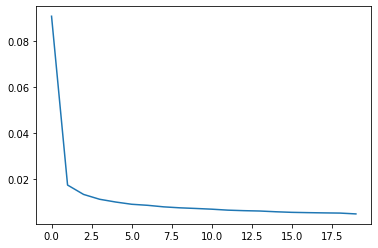

In [54]:
plt.plot(history.history['loss'])

In [60]:
loss, acc = model.evaluate(test_data.iloc[:, :-1], test_data.iloc[:, [-1]])

327/327 [==============================] - 0s 1ms/step - loss: 0.2286 - accuracy: 0.9674
